<a href="https://colab.research.google.com/github/arunsingh22/CaseStudies/blob/master/K-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/drive/My Drive/preprocessed_data.csv",nrows=25000)
data.head(1)


In [ ]:
y = data["project_is_approved"].values
data.project_is_approved.value_counts()

1    21119
0     3881
Name: project_is_approved, dtype: int64

*Remark : Data is highly imbalance*

In [ ]:
X = data.drop(["project_is_approved"],axis=1)

In [ ]:
#Splitting the data into train,CV,test.
train_data,test_data,train_label,test_label = train_test_split(X,y,test_size = 0.3,stratify =y)

print()
print("Train dataset: ",train_data.shape)
print("Test dataset: ",test_data.shape)
print()
print(Counter(train_label))



Train dataset:  (17500, 8)
Test dataset:  (7500, 8)

Counter({1: 14783, 0: 2717})


##**SET 1: Featurizing  the dataset**

In [ ]:
#SET 1: ENCODING USING THE BOW (ESSAY + PROJECT TITLE) 
# Encoding essay into onehot encoding using Countvectorizer/BOW
vect = CountVectorizer()          
BOW_Train_essay = vect.fit_transform(train_data["essay"].values)
print(vect.vocabulary_)

#using the learned vocabulary we encode the CV + test dataset 
BOW_test_essay = vect.transform(test_data["essay"].values)

#Encoding the categorical features School state
vect = CountVectorizer()
vect.fit(train_data.school_state.values)
train_school_state_OHE = vect.transform(train_data["school_state"].values)
test_school_state_OHE = vect.transform(test_data["school_state"].values)

#Encoding the categorical features teacher prefix
vect = CountVectorizer()
vect.fit(train_data.teacher_prefix.values)
train_teacher_prefix_OHE = vect.transform(train_data["teacher_prefix"].values)
test_teacher_prefix_OHE = vect.transform(test_data["teacher_prefix"].values)

#Encoding the categorical features project_grade_category
vect = CountVectorizer()
vect.fit(train_data.project_grade_category.values)
train_project_grade_category_OHE = vect.transform(train_data["project_grade_category"].values)
test_project_grade_category_OHE = vect.transform(test_data["project_grade_category"].values)

#Encoding the categorical features clean_categories	
vect = CountVectorizer()
vect.fit(train_data.clean_categories.values)
train_clean_categories_OHE = vect.transform(train_data["clean_categories"].values)
test_clean_categories_OHE = vect.transform(test_data["clean_categories"].values)

#Encoding the categorical features clean_subcategories	
vect = CountVectorizer()
vect.fit(train_data.clean_subcategories.values)
train_clean_subcategories_OHE = vect.transform(train_data["clean_subcategories"].values)
test_clean_subcategories_OHE = vect.transform(test_data["clean_subcategories"].values)


{'my': 16260, 'students': 23577, 'eager': 7894, 'highly': 11653, 'active': 860, 'curious': 6257, 'imaginative': 12214, 'hands': 11274, 'learners': 14198, 'engaged': 8443, 'daily': 6368, 'rigorous': 20845, 'integrated': 12846, 'academic': 683, 'curriculum': 6274, 'includes': 12413, 'strong': 23545, 'understanding': 25678, 'good': 10783, 'health': 11462, 'practices': 18755, 'physical': 18165, 'education': 8043, 'live': 14554, 'high': 11641, 'poverty': 18727, 'metropolitan': 15554, 'city': 4686, 'attend': 2145, 'title': 24844, 'school': 21440, 'our': 17279, 'inner': 12677, 'lacks': 13946, 'funding': 10298, 'access': 715, 'supplemental': 23872, 'learning': 14202, 'materials': 15202, 'show': 22057, 'class': 4729, 'work': 27137, 'diligently': 7112, 'overcome': 17362, 'many': 15076, 'challenges': 4295, 'face': 9235, 'living': 14568, 'enjoy': 8485, 'working': 27148, 'cooperatively': 5765, 'display': 7325, 'great': 10963, 'creativity': 6040, 'parents': 17639, 'continually': 5642, 'seek': 21655,

####**Importing Project title and encoding**




In [ ]:
project= pd.read_csv("/content/drive/My Drive/Assignment_2/train_data.csv",nrows=25000)
project_title = project["project_title"].values #extracting the project title from the entire file

#Credits: https://colab.research.google.com/drive/1nUiNc5Cb38nTLjUopfNKgPL6g9jZmPY7#scrollTo=d6RCdphRCyn0
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

processed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_title):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split())
    processed_project_title.append(sent.lower().strip())
project_title = processed_project_title

print(project_title)
print("*"*1000)
project_title = pd.Series(project_title) # changing the dtype of project_title
train_project_title,test_project_title = train_test_split(project_title,test_size =0.3)


 29%|██▉       | 7334/25000 [00:00<00:00, 73337.10it/s]

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


100%|██████████| 25000/25000 [00:00<00:00, 77233.27it/s]

['educational support for english learners at home', 'wanted projector for hungry learners', 'soccer equipment for awesome middle school students', 'techie kindergarteners', 'interactive math tools', 'flexible seating for mrs jarvis terrific third graders', 'chromebooks for special education reading program', 'it is the 21st century', 'targeting more success in class', 'just for the love of reading pure pleasure', 'reading changes lives', 'elevating academics and parent rapports through technology', 'building life science experiences', 'everyone deserves to be heard', 'tablets can show us the world', 'making recess active', 'making great leap is with leapfrog', 'technology teaches tomorrow is talents today', 'test time', 'wiggling our way to success', 'magic carpet ride in our library', 'from sitting to standing in the classroom', 'books for budding intellectuals', 'instrumental power conquering steam', 's t e a m challenges science technology engineering art math', 'math masters', 'te

In [ ]:
#BOW encoding of the project Title:
vect = CountVectorizer()
BOW_Train_project_title = vect.fit_transform(train_project_title)
BOW_Test_project_title = vect.transform(test_project_title)

print(BOW_Train_project_title.shape)
print(BOW_Test_project_title.shape)

(17500, 7238)
(7500, 7238)


####**One Hot encoding for categorical features**

**Encoding Numerical Features : Price**






In [ ]:
#Credits :https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=rNl4cZNlPSxK&forceEdit=true&sandboxMode=true 
from sklearn.preprocessing import StandardScaler
stdscalar = StandardScaler()
stdscalar.fit(train_data['price'].values.reshape(-1,1))

train_price = stdscalar.transform(train_data['price'].values.reshape(-1,1))
test_price = stdscalar.transform(test_data['price'].values.reshape(-1,1))

print("After vectorizations")
print(train_price.shape)

After vectorizations
(17500, 1)


**Encoding Numerical Features : teacher_number_of_previously_posted_projects**

In [ ]:
#Credits :https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=rNl4cZNlPSxK&forceEdit=true&sandboxMode=true 
stdscalar = StandardScaler()
stdscalar.fit(train_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

train_prev_posted_proj = stdscalar.transform(train_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_prev_posted_proj = stdscalar.transform(test_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(train_prev_posted_proj.shape)

After vectorizations
(17500, 1)


# **Putting all the features togther using hstack for BOW representation**

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

train = hstack((train_clean_categories_OHE,train_clean_subcategories_OHE,train_project_grade_category_OHE,train_teacher_prefix_OHE,
                  BOW_Train_essay,BOW_Train_project_title,train_prev_posted_proj,train_price,train_school_state_OHE)).tocsr()

test = hstack((test_clean_categories_OHE,test_clean_subcategories_OHE,test_project_grade_category_OHE,test_teacher_prefix_OHE,
               BOW_test_essay,BOW_Test_project_title,test_prev_posted_proj,test_price,test_school_state_OHE)).tocsr()

print(train.shape)
print(test.shape)

(17500, 34815)
(7500, 34815)


### **Data Balancing using Oversampling Technique**

In [ ]:
#Balancing the dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Before bal train_data.shape: ",train.shape,Counter(train_label))
rnd = RandomOverSampler(0.6)
train_BOW,train_label_BOW =rnd.fit_sample(train,train_label)
print("After bal train_data.shape:{0},{1} ",train_BOW.shape,Counter(train_label_BOW))

Before bal train_data.shape:  (17500, 34815) Counter({1: 14783, 0: 2717})
After bal train_data.shape:{0},{1}  (23652, 34815) Counter({1: 14783, 0: 8869})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### **Model 1: Plotting the curve for KNN with BOW**

Fitting 2 folds for each of 35 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 39.0min finished


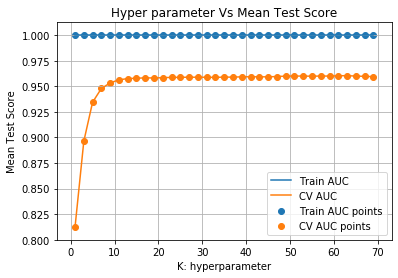

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':range(1,71,2),
              "weights":["distance"],
             }
model = GridSearchCV(clf,parameters, cv=2, scoring='roc_auc',return_train_score=True,verbose=1,)
model.fit(train_BOW, train_label_BOW)

results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean Test Score")
plt.grid()
plt.show()

In [ ]:
print(model.best_score_)
print(model.best_params_)

0.9603645713971068
{'n_neighbors': 63, 'weights': 'distance'}


(23652, 2)


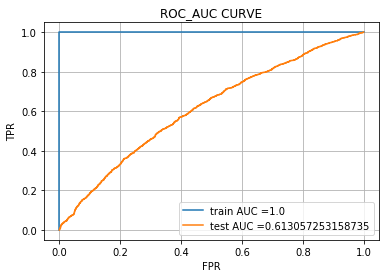


Accuracy: 0.8444

Confusion Metrix:
 [[   0    3]
 [1164 6333]]


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
best_k=63
clf = KNeighborsClassifier(n_neighbors=best_k,weights="distance")
# model1.fit(train,train_label_BOW)
# calibrate model on validation data
model1 = CalibratedClassifierCV(clf, cv=3)
model1.fit(train_BOW,train_label_BOW)

y_train_pred = model1.predict_proba(train_BOW)    
y_test_pred = model1.predict_proba(test) 
print(y_train_pred.shape)

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_BOW, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_AUC CURVE")
plt.grid()
plt.show()

print()
#Prediction
prediction=model1.predict(test)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print()
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))

####**Selecting the top 2000 features for the KNN model.**

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
#reducing the dim of train data.
print("Before dim reduction: ",train.shape)
best_k = SelectKBest(f_classif,k=2000)
best_k.fit(train_BOW,train_label_BOW)
train_BOW = best_k.transform(train_BOW)
print("After dim red: ",train_BOW.shape)

#reducing the dim of test data also.
test=best_k.transform(test)
print(test.shape)


Before dim reduction:  (17500, 34654)
After dim red:  (23652, 2000)
(7500, 2000)


**Training KNN on reduced dim**

Fitting 2 folds for each of 35 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 29.4min finished


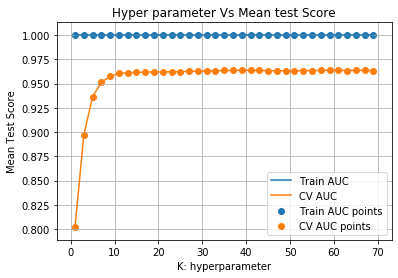

In [ ]:
#Credits:https://www.kaggle.com/mayu0116/hyper-parameters-tuning-of-dtree-rf-svm-knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,accuracy_score,confusion_matrix
#making the instance
clf = KNeighborsClassifier(n_jobs=-1)
#Hyper Parameters Set.
params = {'n_neighbors':range(1,71,2),
           'weights':["distance"],          
         }
model = GridSearchCV(clf,params, cv=2, scoring='roc_auc',return_train_score=True,verbose=1)
model.fit(train_BOW, train_label_BOW)

results = pd.DataFrame.from_dict(model.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score']   
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean test Score")
plt.grid()
plt.show()

In [ ]:
model.best_params_

{'n_neighbors': 65, 'weights': 'distance'}

**Ploting the ROC curve with dim=2000**

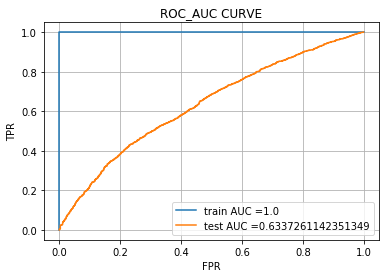

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
best_k=65

clf = KNeighborsClassifier(n_neighbors=best_k,weights="distance",n_jobs=-1)
# model1.fit(train,train_label_BOW)

model1 = CalibratedClassifierCV(clf, cv=3)
model1.fit(train_BOW,train_label_BOW)

y_train_pred = model1.predict_proba(train_BOW)    
y_test_pred = model1.predict_proba(test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_BOW, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_AUC CURVE")
plt.grid()
plt.show()

print()
#Prediction
prediction=model1.predict(test)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print()
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))

##**Model 2: TF-IDF features for KNN**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Encoding the eassay column 
vect = TfidfVectorizer()
train_tfidf_essay =vect.fit_transform(train_data["essay"].values)
print(train_tfidf_essay.shape)

#encodng the same for test essay column also.
test_tfidf_essay =vect.transform(test_data["essay"].values)
print(test_tfidf_essay.shape)

# Encoding the project_title column 
vect = TfidfVectorizer()
train_tfidf_project_title =vect.fit_transform(train_project_title)
print(train_tfidf_project_title.shape)
#encodng the same for test essay column also.
test_tfidf_project_title =vect.transform(test_project_title)
print(test_tfidf_project_title.shape)


(21000, 29361)
(9000, 29361)
(21000, 7864)
(9000, 7864)


In [ ]:
#KNN training of new feature set using TF-IDF
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

train_tfidf = hstack((train_clean_categories_OHE,train_clean_subcategories_OHE,train_project_grade_category_OHE,train_teacher_prefix_OHE,
                  train_tfidf_essay,train_tfidf_project_title,train_prev_posted_proj,train_price,train_school_state_OHE)).tocsr()

test_tfidf = hstack((test_clean_categories_OHE,test_clean_subcategories_OHE,test_project_grade_category_OHE,test_teacher_prefix_OHE,
                    test_tfidf_essay,test_tfidf_project_title,test_prev_posted_proj,test_price,test_school_state_OHE)).tocsr()

print(train_tfidf.shape)
print(test_tfidf.shape)

(21000, 37322)
(9000, 37322)


In [ ]:
#Balancing the dataset 
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Before bal train_data: ",train_tfidf.shape)
print(Counter(train_label))
rnd = RandomOverSampler(0.7)
train_tfidf,train_label_tfidf=rnd.fit_sample(train_tfidf,train_label)
print()
print("After bal train_data.shape:{0},{1} ",train_tfidf.shape,Counter(train_label))

Before bal train_data:  (21000, 37322)
Counter({1: 17761, 0: 3239})

After bal train_data.shape:{0},{1}  (30193, 37322) Counter({1: 17761, 0: 3239})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### **Ploting curve for KNN with Tf-Idf**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 32.6min finished


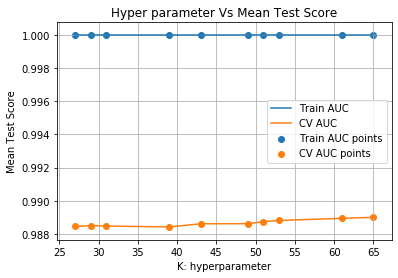

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':range(1,71,2),
              "weights":["distance"],
             }
clf = RandomizedSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True,verbose=1,random_state=99)
clf.fit(train_tfidf, train_label_tfidf)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean Test Score")
plt.grid()
plt.show()



In [ ]:
clf.best_params_

{'n_neighbors': 65, 'weights': 'distance'}

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
best_k=65

clf = KNeighborsClassifier(n_neighbors=best_k,weights="distance")

model1 = CalibratedClassifierCV(clf,cv=3)
model1.fit(train_tfidf,train_label_tfidf)

y_train_pred = model1.predict_proba(train_tfidf)    
y_test_pred = model1.predict_proba(test_tfidf) 


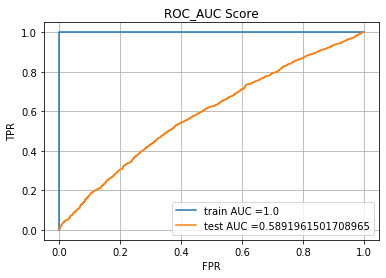


Accuracy: 0.8457777777777777

Confusion Metrix:
 [[   0    0]
 [1388 7612]]


In [ ]:

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_tfidf, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])
K =  results['param_n_neighbors']
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_AUC Score")
plt.grid()
plt.show()

print()
#Prediction
prediction=model1.predict(test_tfidf)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print()
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))

###**Selecting the top 2000 features of Tf-idf for the KNN model.**

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
#reducing the dim of train data.
print(train_tfidf.shape)
best_k_sel = SelectKBest(f_classif,k=2000)
train_tfidf = best_k_sel.fit_transform(train_tfidf,train_label_tfidf)
print(train_tfidf.shape)

#reducing the dim of test data also.
test_tfidf= best_k_sel.transform(test_tfidf)
print(test_tfidf.shape)


(30193, 37322)
(30193, 2000)
(9000, 2000)


### **KNN+tfidf with Dim = 2000**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.9min finished


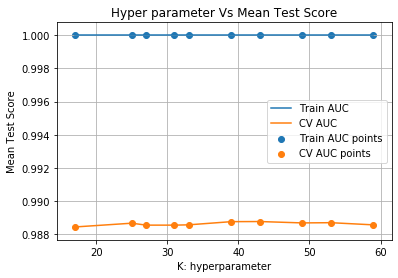

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':range(1,71,2),
              "weights":["distance"],
             }
clf = RandomizedSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True,verbose=1,random_state=42)
clf.fit(train_tfidf, train_label_tfidf)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean Test Score")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'n_neighbors': 43, 'weights': 'distance'}

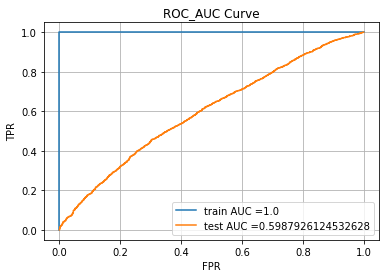

********************************************************************************************************************************************************************************************************
Accuracy: 0.8453333333333334
********************************************************************************************************************************************************************************************************
Confusion Metrix:
 [[   4    8]
 [1384 7604]]


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
best_k=43

clf = KNeighborsClassifier(n_neighbors=best_k,weights="distance")
model1 = CalibratedClassifierCV(clf,cv=3)
model1.fit(train_tfidf,train_label_tfidf)

y_train_pred = model1.predict_proba(train_tfidf)    
y_test_pred = model1.predict_proba(test_tfidf) 

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_tfidf, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_AUC Curve")
plt.grid()
plt.show()

print("*"*200)
#Prediction
prediction=model1.predict(test_tfidf)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print("*"*200)
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))

## **Model 3 : Using Word2Vec model for encoding the text data.**

In [ ]:
# Credits:https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=ka6B7i6vPSx3
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('/content/drive/My Drive/Assignment_2/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#Credits:https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=ka6B7i6vPSx3
#compute average word2vec for each train_project_title
avg_w2v_train_project_title = []; 
for sentence in tqdm(train_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_train_project_title.append(vector)

# compute average word2vec for each test_project_title
avg_w2v_test_project_title = []; 
for sentence in tqdm(test_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_test_project_title.append(vector)

# train_project_title
# CV_project_title
# test_project_title

100%|██████████| 7500/7500 [00:00<00:00, 19160.69it/s]


In [ ]:
#Credits:https://colab.research.google.com/drive/1EkYHI-vGKnURqLL_u5LEf3yb0YJBVbZW#scrollTo=ka6B7i6vPSx3
#compute average word2vec for each train_essay
avg_w2v_train_essay= []; 
for sentence in tqdm(train_data["essay"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_train_essay.append(vector)

# compute average word2vec for each test_essay
avg_w2v_test_essay = []; 
for sentence in tqdm(test_data["essay"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_test_essay.append(vector)
# train_project_title
# CV_project_title
# test_project_title


100%|██████████| 7500/7500 [00:06<00:00, 1128.33it/s]


In [ ]:
#KNN training of new feature set using TF-IDF
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

train_avg_w2v = hstack((train_clean_categories_OHE,train_clean_subcategories_OHE,train_project_grade_category_OHE,train_teacher_prefix_OHE,
                  avg_w2v_train_project_title,avg_w2v_train_essay,train_prev_posted_proj,train_price,train_school_state_OHE)).tocsr()

test_avg_w2v = hstack((test_clean_categories_OHE,test_clean_subcategories_OHE,test_project_grade_category_OHE,test_teacher_prefix_OHE,
                      avg_w2v_test_project_title,avg_w2v_test_essay,test_prev_posted_proj,test_price,test_school_state_OHE)).tocsr()

print(train_avg_w2v.shape)
print(test_avg_w2v.shape)

(17500, 697)
(7500, 697)


In [ ]:
#Balancing the dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Before bal train_data.shape: ",train_avg_w2v.shape,Counter(train_label))
rnd = RandomOverSampler(0.8)
train_avg_w2v,train_label_avgW2V =rnd.fit_sample(train_avg_w2v,train_label)
print("After bal train_data.shape:{0},{1} ",train_avg_w2v.shape,Counter(train_label_avgW2V))

Before bal train_data.shape:  (17500, 697) Counter({1: 14783, 0: 2717})
After bal train_data.shape:{0},{1}  (26609, 697) Counter({1: 14783, 0: 11826})


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import RandomizedSearchCV

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':range(1,71,2),
              "weights":["distance"]}
clf = RandomizedSearchCV(neigh, parameters, scoring='roc_auc',return_train_score=True,verbose=2,cv=2,n_iter=12)
clf.fit(train_avg_w2v, train_label_avgW2V)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean Test Score")
plt.grid()
plt.show()

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] weights=distance, n_neighbors=33 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. weights=distance, n_neighbors=33, total= 8.3min
[CV] weights=distance, n_neighbors=33 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.0min remaining:    0.0s


[CV] ................. weights=distance, n_neighbors=33, total= 4.7min
[CV] weights=distance, n_neighbors=25 ................................
[CV] ................. weights=distance, n_neighbors=25, total= 4.8min
[CV] weights=distance, n_neighbors=25 ................................
[CV] ................. weights=distance, n_neighbors=25, total= 4.8min
[CV] weights=distance, n_neighbors=65 ................................
[CV] ................. weights=distance, n_neighbors=65, total= 4.7min
[CV] weights=distance, n_neighbors=65 ................................
[CV] ................. weights=distance, n_neighbors=65, total= 4.8min
[CV] weights=distance, n_neighbors=27 ................................
[CV] ................. weights=distance, n_neighbors=27, total= 4.8min
[CV] weights=distance, n_neighbors=27 ................................
[CV] ................. weights=distance, n_neighbors=27, total= 4.8min
[CV] weights=distance, n_neighbors=41 ................................


In [ ]:
clf.best_params_

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
best_k= 49

clf = KNeighborsClassifier(n_neighbors=best_k,weights="distance")
model1= CalibratedClassifierCV(clf,cv=3)
model1.fit(train_avg_w2v,train_label_avgW2V)
y_train_pred = model1.predict_proba(train_avg_w2v)    
y_test_pred = model1.predict_proba(test_avg_w2v) 

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_avgW2V, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC Score Plot")
plt.grid()
plt.show()

print()
#Prediction
prediction=model1.predict(test_avg_w2v)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print()
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))

## **Model 4 : Using Tf-idf Word2Vec model for encoding the text data.**

In [ ]:
#Tf-idf Word2Vec model for Essay column
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_data["essay"].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_train_essay_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train_data["essay"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train_essay_vectors.append(vector)

print(len(tfidf_w2v_train_essay_vectors))
print(len(tfidf_w2v_train_essay_vectors[0]))

print("^"*200)

# compute tfidf_avg_word2vec for each test_essay.
tfidf_model.fit(test_data["essay"].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# compute average word2vec for each review.
tfidf_w2v_test_essay_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_data["essay"].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test_essay_vectors.append(vector)

print(len(tfidf_w2v_test_essay_vectors))
print(len(tfidf_w2v_test_essay_vectors[0]))
print()
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### **Tfidf_avg_W2V for project Title**

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_train_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train_project_title.append(vector)

print(len(tfidf_w2v_train_project_title))
print(len(tfidf_w2v_train_project_title[0]))

print("^"*200)

# compute tfidf_avg_word2vec for each test_essay.
tfidf_model.fit(test_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# compute average word2vec for each review.
tfidf_w2v_test_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test_project_title.append(vector)

print(len(tfidf_w2v_test_project_title))
print(len(tfidf_w2v_test_project_title[0]))


In [ ]:
#KNN training of new feature set using TF-IDF
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf_w2v = hstack((train_clean_categories_OHE,train_clean_subcategories_OHE,train_project_grade_category_OHE,train_teacher_prefix_OHE,
                  tfidf_w2v_train_project_title,tfidf_w2v_train_essay_vectors,train_prev_posted_proj,train_price,train_school_state_OHE)).tocsr()

X_test_tfidf_w2v = hstack((test_clean_categories_OHE,test_clean_subcategories_OHE,test_project_grade_category_OHE,test_teacher_prefix_OHE,
                          tfidf_w2v_test_project_title,tfidf_w2v_test_essay_vectors,test_prev_posted_proj,test_price,test_school_state_OHE)).tocsr()

print(X_train_tfidf_w2v.shape)
print(X_test_tfidf_w2v.shape)

In [ ]:
#Balancing the dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Before bal train_data.shape: ",X_train_tfidf_w2v.shape,Counter(train_label))
rnd = RandomOverSampler(0.7)
X_train_tfidf_w2v,train_label_tfidfw2v=rnd.fit_sample(X_train_tfidf_w2v,train_label)
print("After bal train_data.shape:{0},{1} ",X_train_tfidf_w2v.shape,Counter(train_label_tfidfw2v))

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import RandomSearchCV

neigh = KNeighborsClassifier(n_jobs=-1,weights="distance")
parameters = {'n_neighbors':range(2,71,2),
             }
clf = RandomSearchCV(neigh, parameters, cv=3, scoring='roc_auc',return_train_score=True,verbose=2,random_state = 42,n_iter=20)
clf.fit(X_train_tfidf_w2v, train_label_tfidfw2v)

In [ ]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Mean Test Score")
plt.title("Hyper parameter Vs Mean Test Score")
plt.grid()
plt.show()
clf.best_params_

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import  CalibratedClassifierCV
best_k= 60

clf = KNeighborsClassifier(n_neighbors=best_k)
model1= CalibratedClassifierCV(clf,cv=3)
model1.fit(X_train_tfidf_w2v,train_label_tfidfw2v)

y_train_pred = model1.predict_proba(X_train_tfidf_w2v)    
y_test_pred = model1.predict_proba(X_test_tfidf_w2v) 

train_fpr, train_tpr, tr_thresholds = roc_curve(train_label_tfidfw2v, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_label, y_test_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-AUC curve Plot")
plt.grid()
plt.show()
print()
#Prediction
prediction=model1.predict(X_test_tfidf_w2v)
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(prediction,test_label))
print()
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(prediction,test_label))


In [ ]:
from prettytable import PrettyTable    
x = PrettyTable()

x.field_names = ["Model #", "Vectorizer", "Best K", "AUC score"]

x.add_row(["Model 1.0", "BOW",69 , 0.634])
x.add_row(["Model 1.1", "BOW(dim=2k)", 67, 0.50])
x.add_row(["Model 2.0", "Tfidf", 49, 0.46])
x.add_row(["Model 2.2", "Tfidf(dim=2k)", 49, 0.51])
x.add_row(["Model 3.0", "Glove:W2v", 49, 0.48])
x.add_row(["Model 4.0", "Glove:Avg_W2V", 60, 0.55])
print(x)


+-----------+---------------+--------+-----------+
|  Model #  |   Vectorizer  | Best K | AUC score |
+-----------+---------------+--------+-----------+
| Model 1.0 |      BOW      |   69   |   0.634   |
| Model 1.1 |  BOW(dim=2k)  |   67   |    0.5    |
| Model 2.0 |     Tfidf     |   49   |    0.46   |
| Model 2.2 | Tfidf(dim=2k) |   49   |    0.51   |
| Model 3.0 |   Glove:W2v   |   49   |    0.48   |
| Model 4.0 | Glove:Avg_W2V |   60   |    0.55   |
+-----------+---------------+--------+-----------+
